# Reanalysis data exploration

At present, we contrast AVHRR fire data against two different meteorological metrics: FWSL and VPD. 
* VPD: annual mean daily maximum VPD value, from the ERA-5 reanalysis
* FWSL: grand mean of FWSL derived from 5 fire weather metrics calculated from a combination of ERA-5 and MERRA-2 reanalysis products:
  * FWI from GFWED (Merra-2 'prectotcorr' corrected)
  * FWI from GFWED (Merra-2 NCEP-CPC gauge corrected)
  * FWI from CEMS-EFFIS (ERA-5)
  * BI from CEMS-EFFIS (ERA-5)
  * FDI from CEMS-EFFIS (ERA-5)
 
To test the influence of reanalysis, we need to intercompare (1) aggregate MERRA based metrics vs aggregate ERA-5 metrics, and potentially all 5 individual datasets making up FWSL.


In [56]:
import sys
import os
#sys.path.append("/path/to/utils.py")
sys.path.append("C:/Users/mdejong/repos/avhrr_gac_fire/public")
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
##
import utils as utils

In [2]:
# directories
dir_base = "C:/Users/mdejong/OneDrive - NRCan RNCan/projects/avhrr/publication_data"
dir_resamp = os.path.join(dir_base, "03_fire_weather/03_resampled/")
dir_out = os.path.join(dir_base, "reanalysis_investigation/")

fp_avhrr_gfed = os.path.join(dir_base, "GFED_annual_counts_calendaryr.csv")

## 1) check all individual datasets vs the mean
import the GFED region areally weighted means of each ensemble member for the FWSL metric

In [3]:
df = pd.read_csv(os.path.join(dir_base, f"gfed_region_mean_fwsl.csv"))

#identify reanalysis origin of each
df['reanalysis'] = ''
df.loc[df.dataset.str.contains('geff'), 'reanalysis'] = 'ERA5'
df.loc[df.dataset.str.contains('gfwed'), 'reanalysis'] = 'MERRA2'

df.head(2)

,dataset,gfed_name,gfed,year,fwsl_mean,reanalysis
0,gfwed_merra_fwi,BONA,1,1986,2.536516,MERRA2
1,gfwed_merra_fwi,BONA,1,1987,3.246393,MERRA2


regenerate the ensemble, normalised to 1986

In [4]:
# preprocess fwsl
fwsl_mem = df.copy()

#first calc ensemble stats e.g. conf intervals, and then normalise afterwards with 1986 ensemblee mean
fwsl_agg = fwsl_mem.groupby(['gfed', 'gfed_name', 'year'])['fwsl_mean']\
 .agg(['count', 'mean', 'std'])\
 .reset_index()\
 .sort_values(['gfed', 'gfed_name', 'year'], ascending=True)

# ensemble mean values for 1986
fwsl86 = fwsl_agg.loc[fwsl_agg.year == 1986].rename(columns={'mean':'mean86'})

# calc CIs: see https://www.mathsisfun.com/data/confidence-interval-calculator.html
fwsl_agg['ci95'] = 1.96 * fwsl_agg['std'].values / np.sqrt(fwsl_agg['count'].values)
fwsl_agg = fwsl_agg.merge(fwsl86[['gfed','gfed_name','mean86']],
                      how='left',
                      on=['gfed','gfed_name'])

#norm the ensemble stats
fwsl_agg['n_mean'] = fwsl_agg['mean'] / fwsl_agg['mean86'] 
fwsl_agg['n_ci95'] = fwsl_agg['ci95'] / fwsl_agg['mean86'] 

# also norm the ensemble members
fwsl_mem = fwsl_mem.merge(fwsl86[['gfed','gfed_name','mean86']],
                         how='left', 
                         on=['gfed','gfed_name'])

fwsl_mem['n_mean'] = fwsl_mem['fwsl_mean'] / fwsl_mem['mean86']

# drop unused
fwsl_agg = fwsl_agg.drop(['mean86','count'], axis=1)
fwsl_mem = fwsl_mem.drop(['mean86'], axis=1)
fwsl_agg.head(2), fwsl_mem.head(2)

(   gfed gfed_name  year      mean       std      ci95    n_mean    n_ci95
 0     1      BONA  1986  4.377642  3.021627  2.648573  1.000000  0.605023
 1     1      BONA  1987  5.371415  3.699293  3.242574  1.227011  0.740712,
            dataset gfed_name  gfed  year  fwsl_mean reanalysis    n_mean
 0  gfwed_merra_fwi      BONA     1  1986   2.536516     MERRA2  0.579425
 1  gfwed_merra_fwi      BONA     1  1987   3.246393     MERRA2  0.741585)

plot the global totals for all datasets

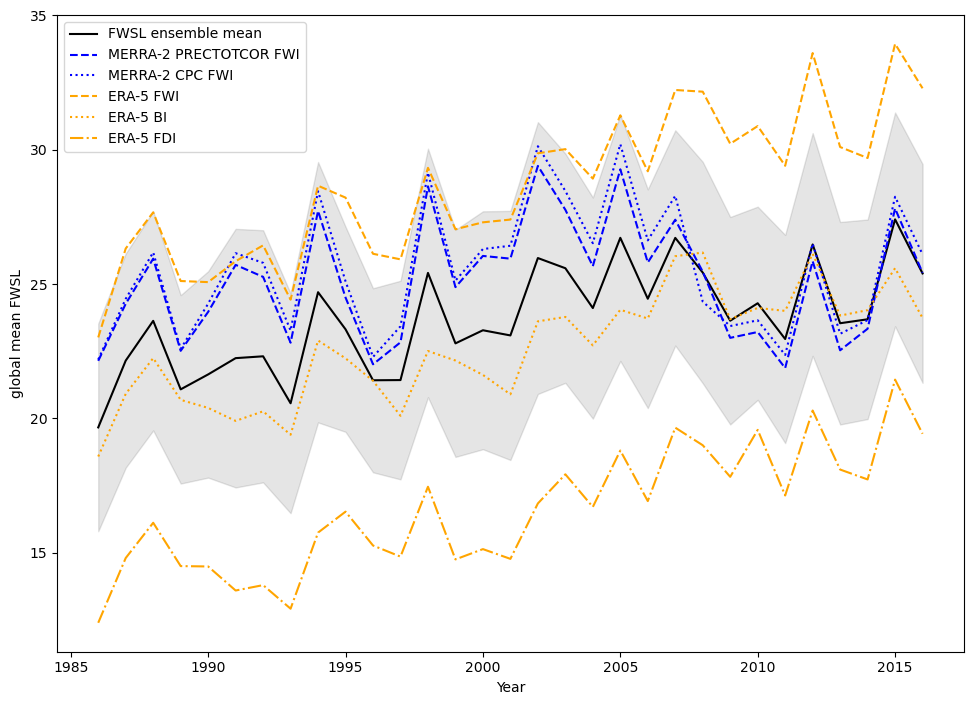

In [5]:
fig, axes = plt.subplots(figsize=(11.7, 8.27), nrows=1, ncols=1,
                         squeeze=True, sharex=False, sharey=False)

df_sub = fwsl_agg.loc[(fwsl_agg.gfed_name=='Global'), :]

# plot the ensemble mean
axes.plot(df_sub.year, df_sub['mean'], label='FWSL ensemble mean', color='k', linestyle='-')

# add the CI
axes.fill_between(df_sub.year, 
                  (df_sub['mean'] - df_sub.ci95), 
                  (df_sub['mean'] + df_sub.ci95), 
                  color='k', alpha=.1)

#lists for plotting
colour_list = ['blue','blue','orange','orange','orange']
line_style_list = ['--',':','--',':','-.']
label_list = ['MERRA-2 PRECTOTCOR FWI', 'MERRA-2 CPC FWI', 'ERA-5 FWI', 'ERA-5 BI', 'ERA-5 FDI']

# add individual datasets
for i, ds in enumerate(['gfwed_merra_fwi', 'gfwed_cpc_fwi', 'geff_fwi', 'geff_bi', 'geff_fdi']):
    df_sub = fwsl_mem.loc[(fwsl_mem.gfed_name=='Global') & (fwsl_mem.dataset==ds), :]
    #label = df.dataset.iloc[0]
    axes.plot(df_sub.year, df_sub.fwsl_mean, label=label_list[i], color=colour_list[i], linestyle=line_style_list[i])

axes.set_ylabel('global mean FWSL')
axes.set_xlabel('Year')
axes.legend()

do the same using the 1986 ensemble mean normalised values (only difference is the y-axis scale)

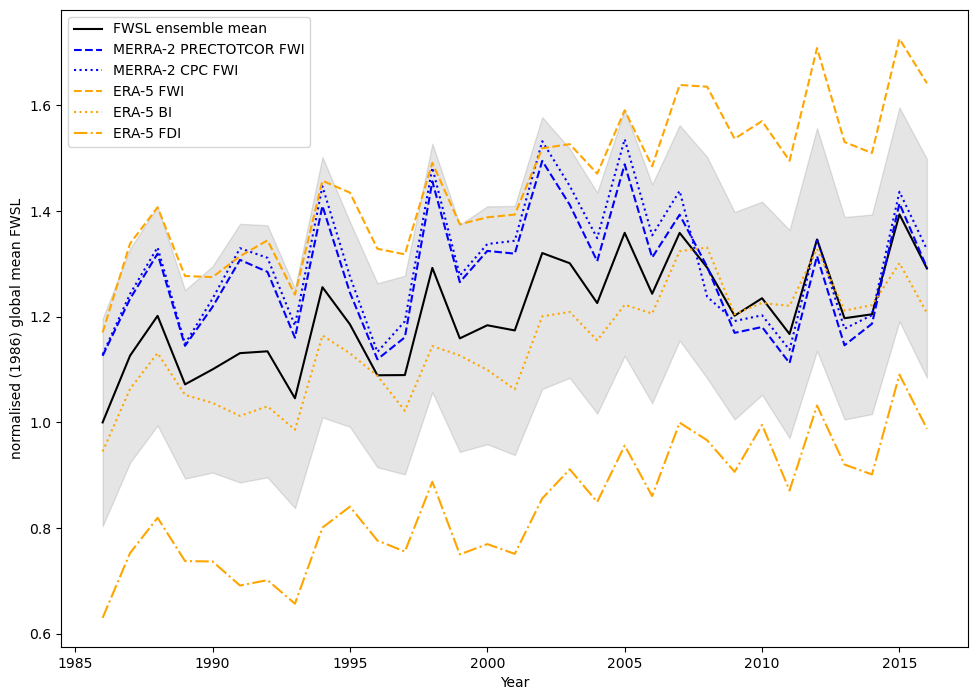

In [6]:
fig, axes = plt.subplots(figsize=(11.7, 8.27), nrows=1, ncols=1,
                         squeeze=True, sharex=False, sharey=False)

df_sub = fwsl_agg.loc[(fwsl_agg.gfed_name=='Global'), :]

# plot the ensemble mean
axes.plot(df_sub.year, df_sub.n_mean, label='FWSL ensemble mean', color='k', linestyle='-')

# add the CI
axes.fill_between(df_sub.year, 
                  (df_sub.n_mean-df_sub.n_ci95), 
                  (df_sub.n_mean+df_sub.n_ci95), 
                  color='k', alpha=.1)

#lists for plotting
colour_list = ['blue','blue','orange','orange','orange']
line_style_list = ['--',':','--',':','-.']
label_list = ['MERRA-2 PRECTOTCOR FWI', 'MERRA-2 CPC FWI', 'ERA-5 FWI', 'ERA-5 BI', 'ERA-5 FDI']

# add individual datasets
for i, ds in enumerate(['gfwed_merra_fwi', 'gfwed_cpc_fwi', 'geff_fwi', 'geff_bi', 'geff_fdi']):
    df_sub = fwsl_mem.loc[(fwsl_mem.gfed_name=='Global') & (fwsl_mem.dataset==ds), :]
    #label = df_sub.dataset.iloc[0]
    axes.plot(df_sub.year, df_sub.n_mean, label=label_list[i], color=colour_list[i], linestyle=line_style_list[i])

axes.set_ylabel('normalised (1986) global mean FWSL')
axes.set_xlabel('Year')
axes.legend()

## 2) Check difference between averages for each reanalysis
* ie average the 3x ERA-5, and 2x MERRA-2 datasets, seperately

In [7]:
#first calc ensemble stats e.g. conf intervals, and then normalise afterwards with 1986 ensemblee mean
fwsl_rea = df.groupby(['gfed', 'gfed_name', 'reanalysis', 'year'])['fwsl_mean']\
 .agg(['count', 'mean', 'std'])\
 .reset_index()\
 .sort_values(['gfed', 'gfed_name', 'year', 'reanalysis'], ascending=True)

# ensemble mean values for 1986
fwsl86 = fwsl_rea.loc[fwsl_rea.year == 1986].rename(columns={'mean':'mean86'})

# calc CIs: see https://www.mathsisfun.com/data/confidence-interval-calculator.html
fwsl_rea['ci95'] = 1.96 * fwsl_rea['std'].values / np.sqrt(fwsl_rea['count'].values)

fwsl_rea = fwsl_rea.merge(fwsl86[['gfed','gfed_name','reanalysis','mean86']],
                      how='left',
                      on=['gfed','gfed_name','reanalysis'])

#norm the ensemble stats
fwsl_rea['n_mean'] = fwsl_rea['mean'] / fwsl_rea['mean86'] 
fwsl_rea['n_ci95'] = fwsl_rea['ci95'] / fwsl_rea['mean86'] 

# drop unused
fwsl_rea = fwsl_rea.drop(['mean86','count'], axis=1)
fwsl_rea.head()

,gfed,gfed_name,reanalysis,year,mean,std,ci95,n_mean,n_ci95
0,1,BONA,ERA5,1986,5.364131,3.805326,4.306132,1.000000,0.802764
1,1,BONA,MERRA2,1986,2.897908,0.511086,0.708328,1.000000,0.244427
2,1,BONA,ERA5,1987,6.451178,4.768863,5.396477,1.202651,1.006030
3,1,BONA,MERRA2,1987,3.751771,0.714712,0.990540,1.294648,0.341812
4,1,BONA,ERA5,1988,8.036210,4.036514,4.567746,1.498138,0.851535


Plot the global ensemble mean, mean by reanalysis, and individual datasets

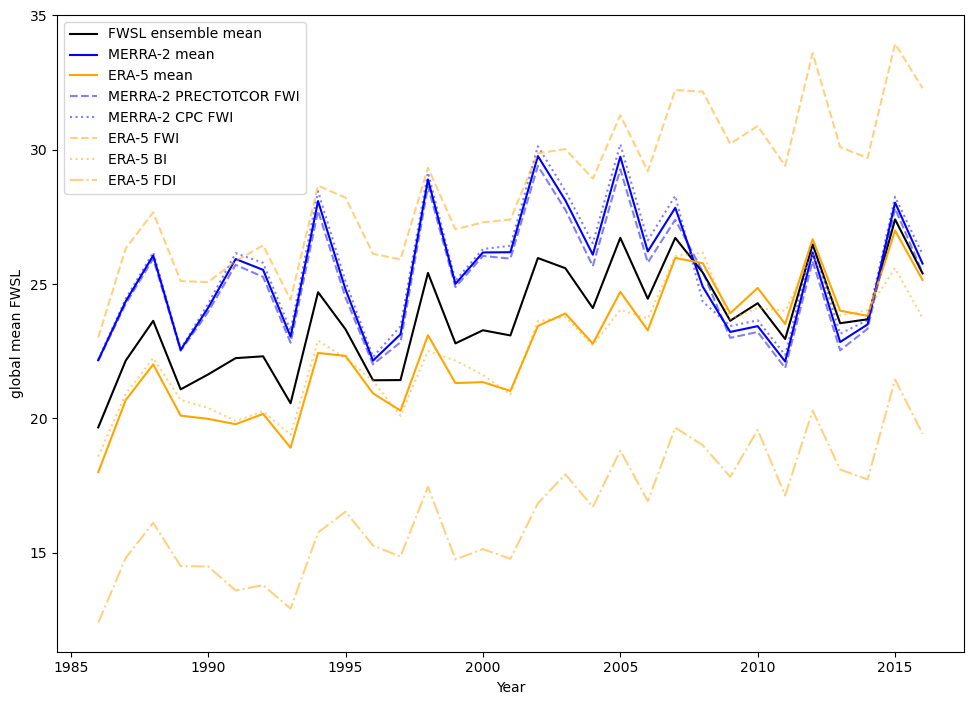

In [8]:
fig, axes = plt.subplots(figsize=(11.7, 8.27), nrows=1, ncols=1,
                         squeeze=True, sharex=False, sharey=False)

df_sub = fwsl_agg.loc[(fwsl_agg.gfed_name=='Global'), :]

# plot the ensemble mean
axes.plot(df_sub.year, df_sub['mean'], label='FWSL ensemble mean', color='k', linestyle='-')

# # add the CI
# axes.fill_between(df_sub.year, 
#                   (df_sub['mean'] - df_sub.ci95), 
#                   (df_sub['mean'] + df_sub.ci95), 
#                   color='k', alpha=.1,
#                   label='FWSL ensemble mean 95% CI')


## ADD REANALYSIS MEANS ===========
#lists for plotting
colour_list = ['blue','orange']
line_style_list = ['-','-']
label_list = ['MERRA-2 mean', 'ERA-5 mean']

# add individual datasets
for i, ds in enumerate(['MERRA2', 'ERA5']):
    df_sub = fwsl_rea.loc[(fwsl_rea.gfed_name=='Global') & (fwsl_rea.reanalysis==ds), :]
    #label = df.dataset.iloc[0]
    axes.plot(df_sub.year, df_sub['mean'], label=label_list[i], color=colour_list[i], linestyle=line_style_list[i])



## ADD INDIVIDUAL MEMBERS ===========
#lists for plotting
colour_list = ['blue','blue','orange','orange','orange']
line_style_list = ['--',':','--',':','-.']
label_list = ['MERRA-2 PRECTOTCOR FWI', 'MERRA-2 CPC FWI', 'ERA-5 FWI', 'ERA-5 BI', 'ERA-5 FDI']

# add individual datasets
for i, ds in enumerate(['gfwed_merra_fwi', 'gfwed_cpc_fwi', 'geff_fwi', 'geff_bi', 'geff_fdi']):
    df_sub = fwsl_mem.loc[(fwsl_mem.gfed_name=='Global') & (fwsl_mem.dataset==ds), :]
    #label = df.dataset.iloc[0]
    axes.plot(df_sub.year, df_sub.fwsl_mean, label=label_list[i], color=colour_list[i], linestyle=line_style_list[i], alpha=0.5)

axes.set_ylabel('global mean FWSL')
axes.set_xlabel('Year')
axes.legend()
fig.savefig(os.path.join(dir_out, '01_global_FWSL_timeseries_all_datasets.png'), dpi=1000)

## 3) Compare regional trends for different reanalyses vs fire

In [9]:
def ts_plotter_fw_flip(df, region_dict, ylab1, ylab2, xlab, av_color_list, fw_color_list, 
                       nrow, ncol, dim = None, ax2rm = None, xlabpad=0, sharex=False):
    """ 
    func for plotting AVHRR vs. meteo dual y-axis plots

    NOTE: there is redundant rounding going on here: both using np.round() and in string formatting
    this is a hangover from previous code iterations

    params:

    df: pandas dataframe, contains the fire count and vpd data to plot
    region_dict: dict, contains breakpoints for different regions (if applicable) 
    ylab1: str, left y axis label
    ylab2: str, right y axis label
    xlab: str, x axis label
    av_color_list: list, hex colours for plotting avhrr components
    fw_color_list: list, hex colours for plotting climate components
    nrow: int, dim of plot panels (n. rows) 
    ncol: int, dim of plot panels (n. columns)  
    dim: tuple of int, figure size. if None, defaults to (12,8)
    ax2rm: int, figure size. if not None, remove this many subaxes from the plot 
    xlabpad: float, pad the xaxis by this much 
    sharex: bool, share x axis, T or F? 
    
    returns:
    fig: figure object 
    axes: axes objects
    stats: df, summary stats 
    
    """
    
    eq_list = ['$\leq$', ' > ']
    
    if dim:
        pass
    else:
        dim=(12,8)      
    
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol,
                           squeeze=False, sharex=sharex,
                           gridspec_kw=dict(hspace=0.35, wspace=0.2))
    axes=axes.flatten()
    
    if ax2rm:   # delete excess axes
        for i in np.arange(ax2rm, 0):
            fig.delaxes(axes[i])
            
    statstable = pd.DataFrame({'region': [],'metric':[],
                           'year_start':[],'year_end' : [], 
                           'tau':[],'p':[],'intercept': [],
                           'slope':[],'lower':[],'upper':[],
                          })
    for i, (key, values) in enumerate(region_dict.items()):
        # print(i, key, values)
        ## if using all years of FW data ('df_outer'), need to remove the nans from matching AVHRR data to plot
        d_fw = df.loc[df.gfed_name==key].copy()
        d_av = df.loc[df.gfed_name==key].copy()    
        d_av = d_av.dropna()   

        x1 = d_fw['year'].values    
        y1 = d_fw['fdi_mean'].values
        y1n = d_fw['fdi_n_mean'].values
        y1_ci = d_fw['fdi_ci95'].values
        
        x2 = d_av['year'].values        
        y2 = d_av['count'].values / 1000        
        y2n = d_av['ncount'].values

        ax1 = axes[i]
        ax2 = ax1.twinx()  # instantiate a second axes obj with same x-axis
        ax1.tick_params(axis='y', labelcolor=av_color_list[2])
        ax2.tick_params(axis='y', labelcolor=fw_color_list[2])
        

        ### points & markers
        #FIRE WEATHER (blues)
        # ax2.fill_between(x1, 
        #                  y1-y1_ci, 
        #                  y1+y1_ci,
        #                  alpha=0.2, edgecolor=fw_color_list[0], facecolor=fw_color_list[0], zorder=1)
        ax2.plot(x1, y1, marker='', ms=4, linestyle='-', color=fw_color_list[0], label=key, alpha=1, zorder=2)
        ax2.plot(x1, y1, marker='s', ms=4, linestyle='none', color=fw_color_list[1], label=key, alpha=1, zorder=2)
        
        #AVHRR (oranges)
        ax1.plot(x2, y2, marker='', ms=4, linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
        ax1.plot(x2, y2, marker='o', ms=4, linestyle='none', color=av_color_list[1], label=key, alpha=1, zorder=2)
      
        # first calc & store the 1986-2016 meteo stats 
        tau1, p1, slope1, intercept1, lower1, upper1 = utils.kendall_theilsen(x1, y1)        
        tau_n1, p_n1, slope_n1, intercept_n1, lower_n1, upper_n1 = utils.kendall_theilsen(x1, y1n)
        statstable.loc[len(statstable)] = [key, 'fireweather', x1[0], x1[-1], 
                         round(tau_n1,6), round(p_n1,6), round(intercept_n1,6), 
                         round(slope_n1,6), round(lower_n1,6), round(upper_n1,6)]    
        # first calc & store the 1986-2016 AVHRR stats      
        tau2, p2, slope2, intercept2, lower2, upper2 = utils.kendall_theilsen(x2, y2)
        tau_n2, p_n2, slope_n2, intercept_n2, lower_n2, upper_n2 = utils.kendall_theilsen(x2, y2n)   
        statstable.loc[len(statstable)] = [key, 'avhrr', x2[0], x2[-1], 
                       round(tau_n2,6), round(p_n2,6), round(intercept_n2,6), 
                       round(slope_n2,6), round(lower_n2,6), round(upper_n2,6)]    

        #PLOT TRENDS ###
        # AVHRR ============
        if values[0]: #i.e. have a change point
            # now do subdivided analysis        
            a = d_av.loc[d_av.year <= values[0]]
            b = d_av.loc[d_av.year >  values[0]]
            for k,dd in enumerate([a,b]):
                x = dd['year'].values        
                y = dd['count'].values / 1000
                yn = dd['ncount'].values
                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)
                tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)            
                if p < 0.1:
                    ax1.plot(x, x * slope + intercept, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'Fire {}{}: {:+.1f} % yr$^1$, p<0.001'.format(eq_list[k], values[0], np.round(slope_n * 100,1)) 
                    else:
                        label=r'Fire {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[0], np.round(slope_n * 100,1), np.round(p_n,3)) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
                else:
                    label=r'Fire {}{}: no trend, p={:.3f}'.format(eq_list[k], values[0], p_n) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                                 round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                                 round(slope_n,6), round(lower_n,6), round(upper_n,6)]
                #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n)
        else: #i.e. no change point
            if p2 < 0.1:
                ax1.plot(x2, x2 * slope2 + intercept2, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                if p2 < 0.001:
                    label=r'Fire 1986-2016: {:+.1f} % yr$^1$, p<0.001'.format(np.round(slope_n2 * 100,1)) 
                else:            
                    label=r'Fire 1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(np.round(slope_n2 * 100,1), np.round(p_n2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
            else:
                label=r'Fire 1986-2016: no trend, p={:.3f}'.format(np.round(p_n2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
            #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n2, )
        
        # WEATHER ===========
        if values[1]:
            # now do subdivided analysis
            a = d_fw.loc[d_fw.year <= values[1]]
            b = d_fw.loc[d_fw.year >  values[1]]
            for k,dd in enumerate([a,b]):
                x = dd['year'].values        
                y = dd['fdi_mean'].values
                yn = dd['fdi_n_mean'].values

                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)        
                tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)        

                if values[0]: # if AVHRRR has a change, change loc of meteo label
                    yloc=0.7 - txt_offset
                else:
                    yloc=0.8 - txt_offset

                if p < 0.1:
                    ax2.plot(x, x * slope + intercept, fw_color_list[1], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'Weather {}{}: {:+.1f} % yr$^1$, p<0.001'.format(eq_list[k], values[1], np.round(slope_n * 100,1)) 
                    else:
                        label=r'Weather {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[1], np.round(slope_n * 100,1), np.round(p_n,3)) 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)
                else:
                    label=r'Weather {}{}: p={:.3f}'.format(eq_list[k], values[1], np.round(p_n,3)) 
                    label=r'Weather {}{}: no trend, p={:.3f}'.format(eq_list[k], values[1], np.round(p_n,3))                 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'fireweather', x[0], x[-1], 
                                 round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                                 round(slope_n,6), round(lower_n,6), round(upper_n,6)]
        else:
            txt_offset = 1 * 0.1
            if values[0]: # if AVHRRR has a change
                yloc=0.7
            else:
                yloc=0.9 - txt_offset        
            if p1 < 0.1:
                ax2.plot(x1, x1 * slope1 + intercept1, fw_color_list[1], linewidth=2, linestyle='-', zorder=1000)
                if p1 < 0.001:
                    label=r'Weather 1986-2016: {:+.1f} % yr$^1$, p<0.001'.format(np.round(slope_n1 * 100,1)) 
                else:
                    label=r'Weather 1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(np.round(slope_n1 * 100,1), np.round(p_n1,3)) 
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)
            else:
                label=r'Weather 1986-2016: p={:.3f}'.format(np.round(p_n1,3))
                label=r'Weather 1986-2016: no trend, p={:.3f}'.format(np.round(p_n1,3))
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)        
        #print(d_fw.gfed_full_name.values[0], p_n1)
        
        # tidy up subplot
        ax1.set_title(d_av.gfed_full_name.values[0], fontsize=10)   
        # expand upper y limits for text
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)
        ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1] * 1.1) 
        #ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
        # adjust tick label font sizes
        ax1.tick_params(axis='both', which='major', labelsize=8)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        ax2.tick_params(axis='both', which='major', labelsize=8)
        ax2.tick_params(axis='both', which='minor', labelsize=8)
        
    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.set_xlabel(xlab, color='k', fontsize=10, labelpad=xlabpad)
    ax1.set_ylabel(ylab2, color=av_color_list[2], fontsize=10, labelpad=0)  #20  
    ax2.set_ylabel(ylab1, color=fw_color_list[2], fontsize=10)
    plt.box(False)
    ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    return fig, axes, statstable

In [10]:
# colour palettes for plotting
av_color_list = ['#fec44f','#ec7014','#cc4c02'] #oranges  #fe9929
fw_color_list = ['#dcdcdc','#bdbdbd','#969696'] #greys
#params for figure set up
mm = 1/25.4

In [11]:
# get the fire data used in trend plots and format
df_fire = pd.read_csv(fp_avhrr_gfed)
df_fire = df_fire.loc[df_fire.gfed_name!='Mask']

df_fire.loc[df_fire.gfed_name=='global', 'gfed_name'] = 'Global'

# normalise ANF to 1986
df_fire86 = df_fire.loc[df_fire.year == 1986].rename(columns={'count':'count86'})
df_fire = df_fire.merge(df_fire86[['gfed','gfed_name','count86']], how='left', 
                        on=['gfed','gfed_name'])
df_fire['ncount'] = df_fire['count'] / df_fire['count86']
df_fire = df_fire.drop('count86', axis=1)

# make more readable names
df_fire['gfed_full_name'] = ''
df_fire.loc[df_fire.gfed_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
df_fire.loc[df_fire.gfed_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
df_fire.loc[df_fire.gfed_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
df_fire.loc[df_fire.gfed_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere South America (NHSA)'
df_fire.loc[df_fire.gfed_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere South America (SHSA)'
df_fire.loc[df_fire.gfed_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
df_fire.loc[df_fire.gfed_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
df_fire.loc[df_fire.gfed_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere Africa (NHAF)'
df_fire.loc[df_fire.gfed_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere Africa (SHAF)'
df_fire.loc[df_fire.gfed_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
df_fire.loc[df_fire.gfed_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
df_fire.loc[df_fire.gfed_name=='SEAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
df_fire.loc[df_fire.gfed_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
df_fire.loc[df_fire.gfed_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
df_fire.loc[df_fire.gfed_name=='Global', 'gfed_full_name'] = 'Global'

print(np.unique(df_fire.gfed_name))
df_fire.head(2)

['AUST' 'BOAS' 'BONA' 'CEAM' 'CEAS' 'EQAS' 'EURO' 'Global' 'MIDE' 'NHAF'
 'NHSA' 'SEAS' 'SHAF' 'SHSA' 'TENA']


,sat_yr,sat,year,gfed,gfed_name,count,ncount,gfed_full_name
0,NF1986,NF,1986,1,BONA,237,1.0,Boreal North America (BONA)
1,NF1986,NF,1986,2,TENA,597,1.0,Temperate North America (TENA)


In [12]:
#rename some cols in fwsl before joinng with avhrr
fwsl_agg = fwsl_agg.rename(columns={'mean':'fdi_mean', 
                                    'std':'fdi_std', 
                                    'ci95':'fdi_ci95', 
                                    'n_mean':'fdi_n_mean', 
                                    'n_ci95':'fdi_n_ci95'})

fwsl_rea = fwsl_rea.rename(columns={'mean':'fdi_mean', 
                                    'std':'fdi_std', 
                                    'ci95':'fdi_ci95', 
                                    'n_mean':'fdi_n_mean', 
                                    'n_ci95':'fdi_n_ci95'})

merra = fwsl_rea.loc[(fwsl_rea.reanalysis=='MERRA2'), :]
era = fwsl_rea.loc[(fwsl_rea.reanalysis=='ERA5'), :]

In [13]:
# combine
df_outer_ensemble = fwsl_agg.merge(df_fire, how='outer', on=['year','gfed','gfed_name'])
df_outer_merra = merra.merge(df_fire, how='outer', on=['year','gfed','gfed_name'])
df_outer_era = era.merge(df_fire, how='outer', on=['year','gfed','gfed_name'])
#fix naming issue
df_outer_ensemble.loc[df_outer_ensemble.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'
df_outer_merra.loc[df_outer_merra.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'
df_outer_era.loc[df_outer_era.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'

## use this file in R to get break points, and also to plot boxplots (MS figure 4) of all variables
df_outer_merra.to_csv(os.path.join(dir_out, f'avhrr_and_fire_weather_merra_fulljoin_1986-2016.csv'),index=False)
df_outer_era.to_csv(os.path.join(dir_out, f'avhrr_and_fire_weather_era_fulljoin_1986-2016.csv'),index=False)

### rerun full ensemble of FWSL
* no valid FWSL change points (CP within 1993-2009, 95%CI < 10, CI extend within 1986-2016)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\1225149424.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


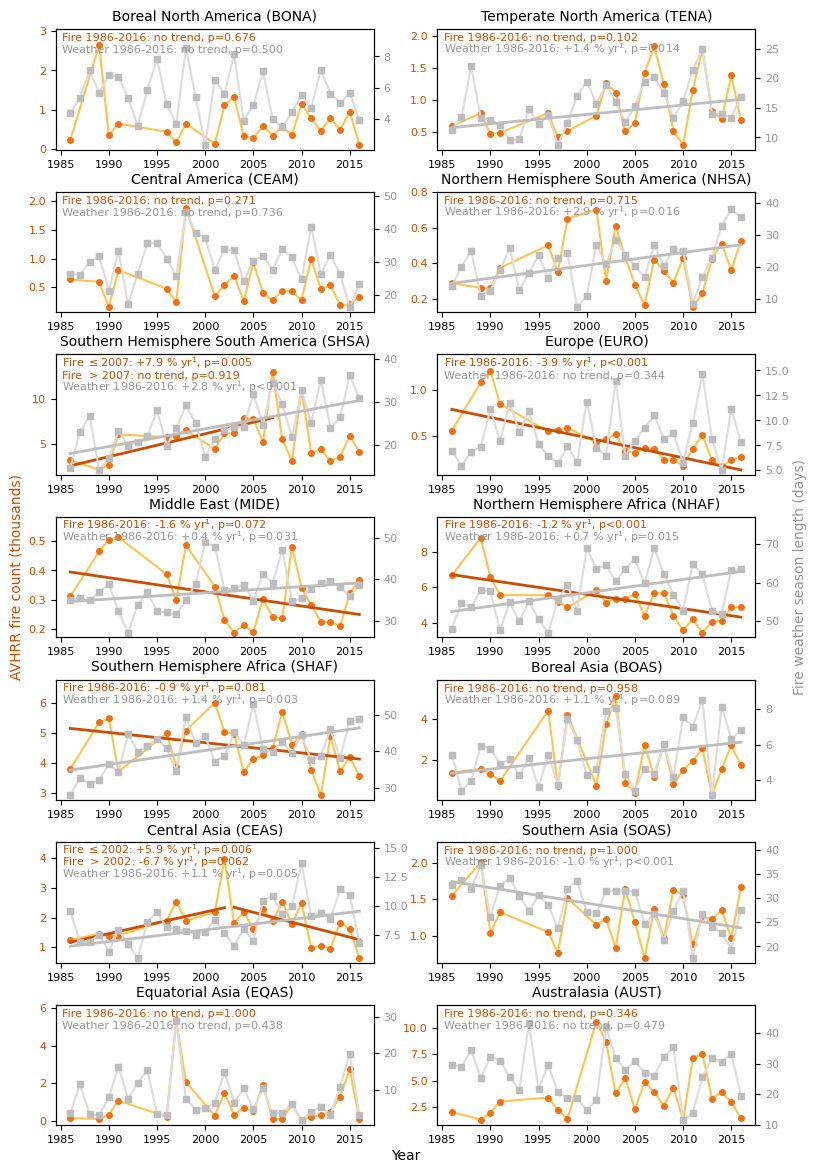

In [14]:
region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, None], 
               'NHSA':  [None, None],  
               'SHSA':  [2007, None],
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, None], 
               'SHAF':  [None, None], 
               'BOAS':  [None, None],
               'CEAS':  [2002, None], 
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None]
              }

## FLIPPED VERSIONS
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer_ensemble, region_dict=region_dict, 
                           ylab1="Fire weather season length (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=7, ncol=2, dim = (210*mm,297*mm))
fig.tight_layout()

#figs
fig.savefig(os.path.join(dir_out, 'timeseries_gfed_fwsl_ensemble.png'), dpi=1000)
#fig.savefig(os.path.join(dir_out_figures, 's5_timeseries_gfed_fwsl_flip.pdf'))

#statstable
stats_tbl.to_csv(os.path.join(dir_out, 'timeseries_gfed_fwsl_ensemble.csv'),index=False)

### MERRA-2
* valid FWSL change poins in NHAF and SHAF (CP within 1993-2009, 95%CI < 10, CI extend within 1986-2016)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\2204785552.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


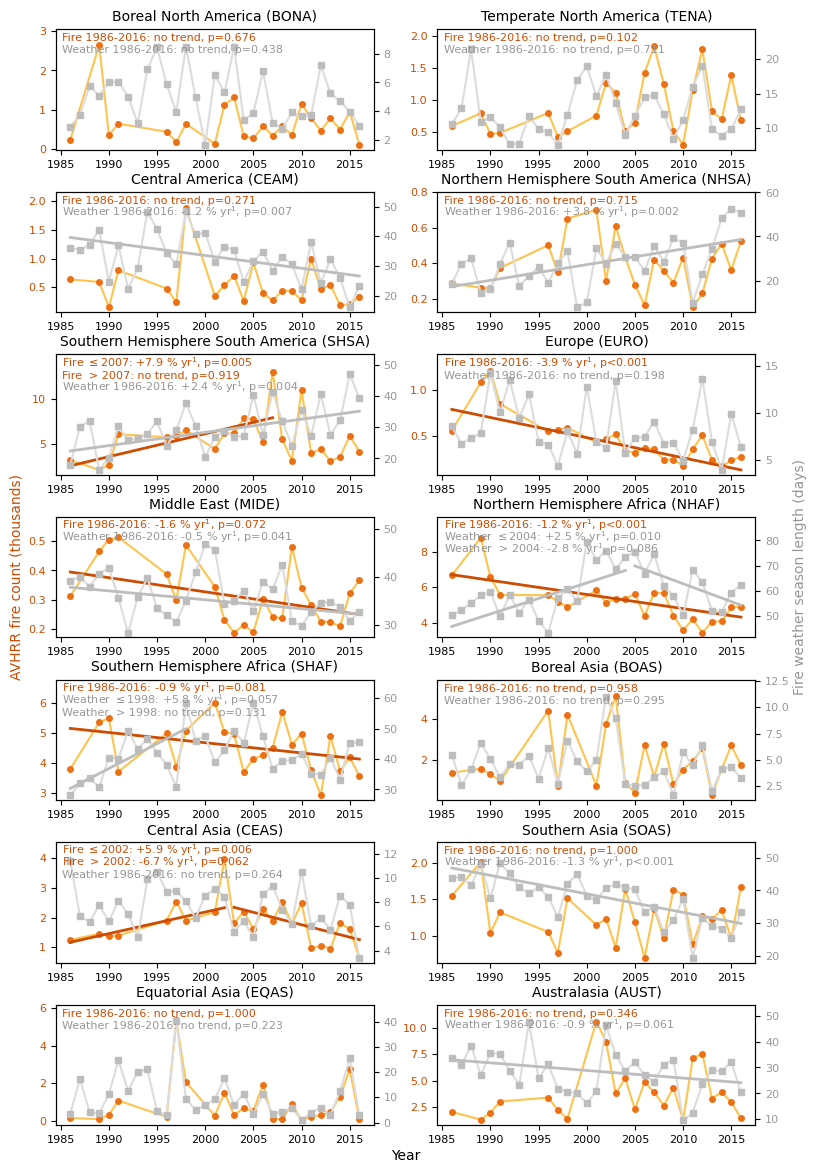

In [15]:
region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, None], 
               'NHSA':  [None, None],  
               'SHSA':  [2007, None],
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, 2004], 
               'SHAF':  [None, 1998], 
               'BOAS':  [None, None],
               'CEAS':  [2002, None], 
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None]
              }

## FLIPPED VERSIONS
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer_merra, region_dict=region_dict, 
                           ylab1="Fire weather season length (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=7, ncol=2, dim = (210*mm,297*mm))
fig.tight_layout()

#figs
fig.savefig(os.path.join(dir_out, 'timeseries_gfed_fwsl_merra2.png'), dpi=1000)
#fig.savefig(os.path.join(dir_out_figures, 's5_timeseries_gfed_fwsl_flip.pdf'))

#statstable
stats_tbl.to_csv(os.path.join(dir_out, 'timeseries_gfed_fwsl_merra2.csv'),index=False)

### ERA-5
* no valid FWSL change points (CP within 1993-2009, 95%CI < 10, CI extend within 1986-2016)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\2649236831.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


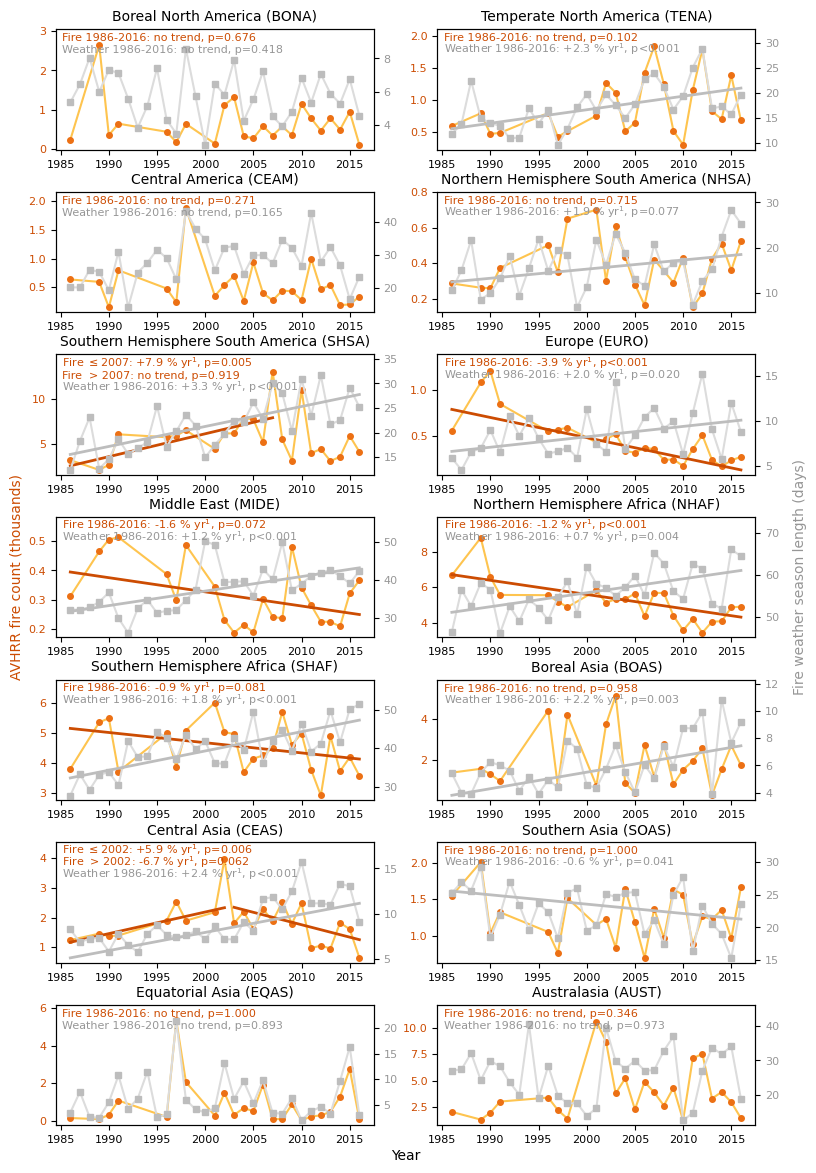

In [16]:
region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, None], 
               'NHSA':  [None, None],  
               'SHSA':  [2007, None],
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, None], 
               'SHAF':  [None, None], 
               'BOAS':  [None, None],
               'CEAS':  [2002, None], 
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None]
              }

## FLIPPED VERSIONS
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer_era, region_dict=region_dict, 
                           ylab1="Fire weather season length (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=7, ncol=2, dim = (210*mm,297*mm))
fig.tight_layout()

#figs
fig.savefig(os.path.join(dir_out, 'timeseries_gfed_fwsl_era5.png'), dpi=1000)
#fig.savefig(os.path.join(dir_out_figures, 's5_timeseries_gfed_fwsl_flip.pdf'))

#statstable
stats_tbl.to_csv(os.path.join(dir_out, 'timeseries_gfed_fwsl_era5.csv'),index=False)

### now plot the global for each

C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\2424183086.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\2424183086.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\2424183086.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\2424183086.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


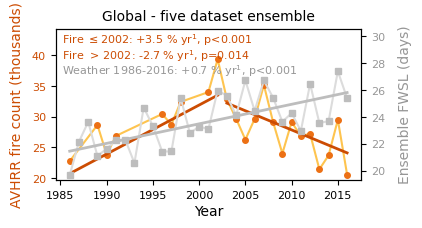

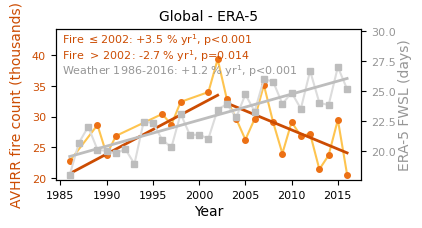

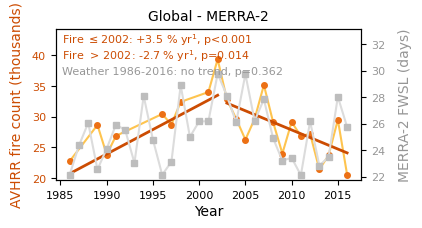

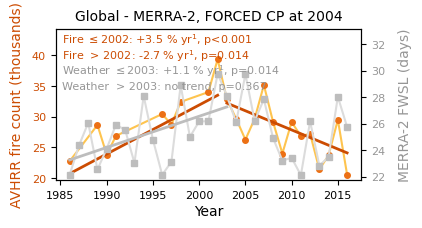

In [17]:
# Ensemble - same as in manuscript
region_dict = {'Global':[2002, None]}
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer_ensemble, region_dict=region_dict, 
                           ylab1="Ensemble FWSL (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=1, ncol=1, dim = (100*mm,50*mm), xlabpad=0) 
axes[0].set_title('Global - five dataset ensemble', fontsize=10)   
fig.tight_layout()
fig.savefig(os.path.join(dir_out, '02_global_trends_FWSL_ensemble.png'), dpi=1000, bbox_inches = 'tight')

# ERA-5
region_dict = {'Global':[2002, None]}
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer_era, region_dict=region_dict, 
                           ylab1="ERA-5 FWSL (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=1, ncol=1, dim = (100*mm,50*mm), xlabpad=0) 
axes[0].set_title('Global - ERA-5', fontsize=10)   
fig.tight_layout()
fig.savefig(os.path.join(dir_out, '02_global_trends_FWSL_ERA5.png'), dpi=1000, bbox_inches = 'tight')

# MERRA
region_dict = {'Global':[2002, None]}
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer_merra, region_dict=region_dict, 
                           ylab1="MERRA-2 FWSL (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=1, ncol=1, dim = (100*mm,50*mm), xlabpad=0) 
axes[0].set_title('Global - MERRA-2', fontsize=10)   
fig.tight_layout()
fig.savefig(os.path.join(dir_out, '02_global_trends_FWSL_MERRA2.png'), dpi=1000, bbox_inches = 'tight')

# MERRA (FORCE A CHANGE POINT THAT WOULD REQUIRE RELAXATION OF CP CRITERIA: 95%CI is 14 years)
region_dict = {'Global':[2002, 2003]}
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer_merra, region_dict=region_dict, 
                           ylab1="MERRA-2 FWSL (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=1, ncol=1, dim = (100*mm,50*mm), xlabpad=0) 
axes[0].set_title('Global - MERRA-2, FORCED CP at 2004', fontsize=10)   
fig.tight_layout()
fig.savefig(os.path.join(dir_out, '02_global_trends_FWSL_MERRA2_forced_change_pnt.png'), dpi=1000, bbox_inches = 'tight')

## 4) Map linear trends in different FWSL
* reproduce the mapped linear trends used for VPD and ensemble of FWSL (manuscript Fig 2) but for the ERA-5 and MERRA-2 only datasets


In [18]:
merra_arr = np.load(os.path.join(dir_resamp, "fwi_days_ensemble_gfwed_1986_2016_resampled_0p1deg.npz"))['arr_0']
era_arr = np.load(os.path.join(dir_resamp, "fwi_days_ensemble_geff_1986_2016_resampled_0p1deg.npz"))['arr_0']

In [19]:
# if coarsen > 1, spatial resolution will be coarsened by aggregating this 
# many input grid cells (if input is 0.1 deg, coarsen == 20 -> 2 degree grid)
coarsen = 20
# list of years to compile
all_years = np.arange(1986,2016+1)
# define input grid parameters
res = 0.1
# matplotlib expects plotting in inches, this conversion factor lets us specify it in mm
mm = 1/25.4

# get evenly spaced lat/lons
lat1d_raw = np.linspace(90. - res / 2., -90. + res / 2., num=int(180 / res))
lon1d_raw = np.linspace(0. + res / 2., 360. - res / 2., num=int(360 / res)) - 180
offset_raw = abs(lon1d_raw[0] - lon1d_raw[1]) / 2
lon2d_raw, lat2d_raw = np.meshgrid(lon1d_raw, lat1d_raw)

# recalc these if inputs should be coarsened
if coarsen != 1:
    lat1d = np.linspace(lat1d_raw[:coarsen].mean(), lat1d_raw[-coarsen:].mean(), int(lat1d_raw.shape[0] / coarsen))
    lon1d = np.linspace(lon1d_raw[:coarsen].mean(), lon1d_raw[-coarsen:].mean(), int(lon1d_raw.shape[0] / coarsen))
else:
    lat1d = lat1d_raw
    lon1d = lon1d_raw

# get corresponding 2D grids of lat/lon
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

#useful for plotting
pixel_spacing = int(lat1d[0] - lat1d[1])
offset = abs(lon1d[0] - lon1d[1]) / 2

### MERRA PLOTTING

In [20]:
efwsl = merra_arr.copy()

# identify nans with mask
nan_mask = np.isnan(efwsl).astype(int)
if len(nan_mask.shape) < 3:
    nan_mask = nan_mask[np.newaxis,:,:]
efwsl[np.isnan(efwsl)] = 1 # turn all nans into 1s

# calculate SUM at new res (this will = x + 1 * no. of nan cells)
efwsl2, lat1d_2, lon1d_2 = utils.grid_coarsen_v2(arr=efwsl, lat1d=lat1d_raw, 
                                           lon1d=lon1d_raw, factor=coarsen, algo='sum')

# how many nans were in each NEW resolution grid cell?
nan_new = np.zeros([nan_mask.shape[0], int(nan_mask.shape[1]/coarsen), int(nan_mask.shape[2]/coarsen)])   
for z in range(nan_mask.shape[0]):
    for i in range(coarsen):
        for j in range(coarsen):
            nan_new[z] += nan_mask[z,i::coarsen, j::coarsen]
print(nan_new.shape)

# remove influence of nans (1s) from sum 
efwsl2 = efwsl2 - nan_new

# calc mean by dividing by the number of valid (non-nan) grid cells
# 100% nan cells get reset to NaN due to dividebyzero
nvalid = coarsen**2 - nan_new
efwsl2 = efwsl2 / nvalid

# mask the arctic 
#1 grid cell = 2deg so 15 grid cells = 30deg (90-30=60)
efwsl2[:,0:15,:] = np.nan

(31, 90, 180)


C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\1455834428.py:27: RuntimeWarning: invalid value encountered in divide
  efwsl2 = efwsl2 / nvalid


calculate trends

In [21]:
merra_tau, merra_tau_p, merra_sen = utils.grid_kendall_no_nan_v2(efwsl2, all_years, 
                                                                 norm=False, thresh=1)

# mask based on p < 0.1
merra_tau_p_mask = (merra_tau_p < 0.1).astype(float)  # 1= sig, 0 = not sig
merra_tau_masked = merra_tau * merra_tau_p_mask  # set not sig areas to zero

C:\Users/mdejong/repos/avhrr_gac_fire/public\utils.py:488: RuntimeWarning: invalid value encountered in scalar divide
  extreme_prop = extremes / len(fires)


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


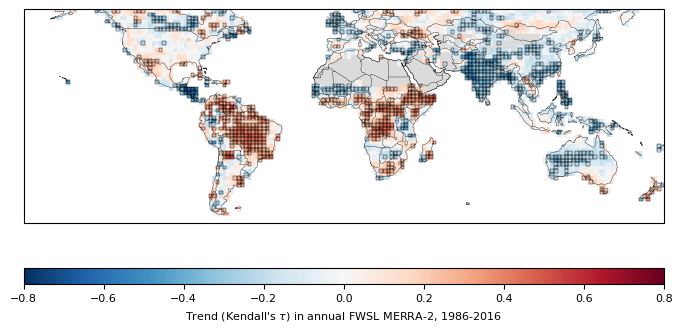

In [22]:
y = lat2d[np.where((merra_tau_masked!=0)&(~np.isnan(merra_tau_masked)))]
x = lon2d[np.where((merra_tau_masked!=0)&(~np.isnan(merra_tau_masked)))]

fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60],
                            arr=merra_tau,
                            grid_options=None,
                            mesh_options={'norm': mpl.colors.Normalize(vmin=-0.8, vmax=0.8), 
                                          'cmap': 'RdBu_r'},
                            draw_features=['land', 'coast', 'countries']#'lakes'
                           )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k',
           facecolor='none',
           linewidth=0.3)

utils.colorbar_v4(fig, ax, mesh, cblab=r"Trend (Kendall's $\tau$) in annual FWSL MERRA-2, 1986-2016", 
            cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 40}, 
            cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(os.path.join(dir_out, '03_fwsl_trend_map_MERRA2.png'), dpi=1000)
#fig.savefig(os.path.join(dir_out_figures, '02_fwsl_trend_map.pdf'))

### ERA-5 PLOTTING

In [23]:
efwsl = era_arr.copy()

# identify nans with mask
nan_mask = np.isnan(efwsl).astype(int)
if len(nan_mask.shape) < 3:
    nan_mask = nan_mask[np.newaxis,:,:]
efwsl[np.isnan(efwsl)] = 1 # turn all nans into 1s

# calculate SUM at new res (this will = x + 1 * no. of nan cells)
efwsl2, lat1d_2, lon1d_2 = utils.grid_coarsen_v2(arr=efwsl, lat1d=lat1d_raw, 
                                           lon1d=lon1d_raw, factor=coarsen, algo='sum')

# how many nans were in each NEW resolution grid cell?
nan_new = np.zeros([nan_mask.shape[0], int(nan_mask.shape[1]/coarsen), int(nan_mask.shape[2]/coarsen)])   
for z in range(nan_mask.shape[0]):
    for i in range(coarsen):
        for j in range(coarsen):
            nan_new[z] += nan_mask[z,i::coarsen, j::coarsen]
print(nan_new.shape)

# remove influence of nans (1s) from sum 
efwsl2 = efwsl2 - nan_new

# calc mean by dividing by the number of valid (non-nan) grid cells
# 100% nan cells get reset to NaN due to dividebyzero
nvalid = coarsen**2 - nan_new
efwsl2 = efwsl2 / nvalid

# mask the arctic 
#1 grid cell = 2deg so 15 grid cells = 30deg (90-30=60)
efwsl2[:,0:15,:] = np.nan

(31, 90, 180)


C:\Users\mdejong\AppData\Local\Temp\ipykernel_21100\2268813497.py:27: RuntimeWarning: invalid value encountered in divide
  efwsl2 = efwsl2 / nvalid


In [24]:
era_tau, era_tau_p, era_sen = utils.grid_kendall_no_nan_v2(efwsl2, all_years, 
                                                                 norm=False, thresh=1)

# mask based on p < 0.1
era_tau_p_mask = (era_tau_p < 0.1).astype(float)  # 1= sig, 0 = not sig
era_tau_masked = era_tau * era_tau_p_mask  # set not sig areas to zero

C:\Users/mdejong/repos/avhrr_gac_fire/public\utils.py:488: RuntimeWarning: invalid value encountered in scalar divide
  extreme_prop = extremes / len(fires)


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


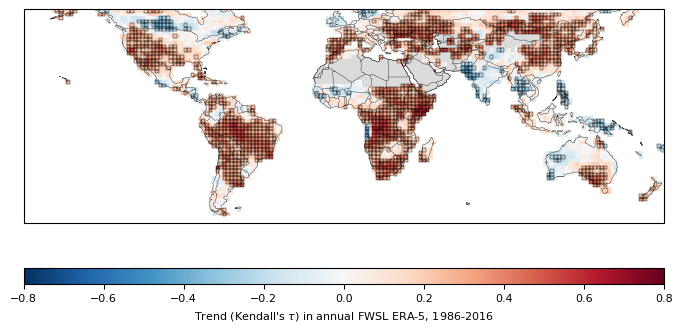

In [25]:
y = lat2d[np.where((era_tau_masked!=0)&(~np.isnan(era_tau_masked)))]
x = lon2d[np.where((era_tau_masked!=0)&(~np.isnan(era_tau_masked)))]

fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60],
                            arr=era_tau,
                            grid_options=None,
                            mesh_options={'norm': mpl.colors.Normalize(vmin=-0.8, vmax=0.8), 
                                          'cmap': 'RdBu_r'},
                            draw_features=['land', 'coast', 'countries']#'lakes'
                           )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k',
           facecolor='none',
           linewidth=0.3)

utils.colorbar_v4(fig, ax, mesh, cblab=r"Trend (Kendall's $\tau$) in annual FWSL ERA-5, 1986-2016", 
            cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 40}, 
            cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(os.path.join(dir_out, '03_fwsl_trend_map_ERA5.png'), dpi=1000)
#fig.savefig(os.path.join(dir_out_figures, '02_fwsl_trend_map.pdf'))

### check to see how well these trends (mis)align with fire

In [26]:
# 1 colour cmap (grey) used to indicate frequent fire activity
flat_cmap = mpl.colors.ListedColormap(['#b3b3b3', '#b3b3b3'])

# 1 colour cmap (blue) used in supp mat. maps
flat_cmap_blue = mpl.colors.ListedColormap(['#6495ED', '#6495ED'])

# 5 colour discrete cmap used for comparing trend in fire and VPD/FWSL
discrete_cmap_list = [[30, 120, 180], # blue
                      [202, 0, 32],  # red
                      [239, 209, 69],  # yellow
                      [127, 205, 187],  # teal
                      [255, 255, 255]]  # white
discrete_cmap = utils.list_to_listed_cmap(discrete_cmap_list)

In [27]:
av_t = np.load(os.path.join(dir_base, 'outputs/01_avhrr_fire_trend_map_tau.npy'))
av_t_masked = np.load(os.path.join(dir_base, 'outputs/01_avhrr_fire_trend_map_tau_masked_to_pval0p1.npy'))

grid cells with frequent fire: 2045
grid cells with a fire trend: 415
total coincident trends: 218 52.53012048192771
both down: 11 2.6506024096385543
both up: 81 19.518072289156628
fire up climate down: 2 0.48192771084337355
fire down climate up: 124 29.87951807228916
fire trend but no climate trend: 197 47.46987951807229
n agreeing: 92 22.16867469879518
NOTE: discrete colorbar specified. ensure that ticks match ticklabs! tickrange=1-5 clim=0.5-5.5, offset=0.5


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


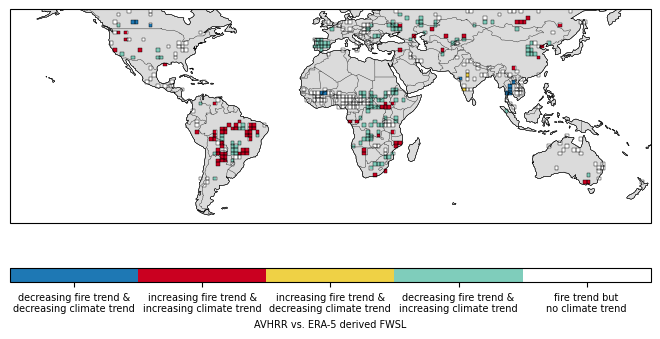

In [28]:
# the array of AVHRR Kendalls tau where p value < 0.1
fires=av_t_masked.copy()  

fwsl_quadrant = np.ones_like(fires) * np.nan
fwsl_quadrant[~np.isnan(fires)] = 5  #this will be the locations where trend in fire but no trend in fw
fwsl_quadrant[(era_tau_masked<0)&(fires<0)] = 1
fwsl_quadrant[(era_tau_masked>0)&(fires>0)] = 2
fwsl_quadrant[(era_tau_masked<0)&(fires>0)] = 3
fwsl_quadrant[(era_tau_masked>0)&(fires<0)] = 4

# fwsl_quadrant has values 1-4 & nan
nf = 2045 #np.sum(~np.isnan(firescount))
nn = np.sum(~np.isnan(fwsl_quadrant))
n1 = np.sum(fwsl_quadrant==1)
n2 = np.sum(fwsl_quadrant==2)
n3 = np.sum(fwsl_quadrant==3)
n4 = np.sum(fwsl_quadrant==4)
n5 = np.sum(fwsl_quadrant==5)
print('grid cells with frequent fire:', nf)
print('grid cells with a fire trend:', nn)
print('total coincident trends:', n1+n2+n3+n4, (n1+n2+n3+n4)/nn*100)
print('both down:', n1, n1/nn*100)
print('both up:', n2, n2/nn*100)
print('fire up climate down:', n3, n3/nn*100)
print('fire down climate up:', n4, n4/nn*100)
print('fire trend but no climate trend:', n5, n5/nn*100)
print('n agreeing:', n1+n2, (n1+n2)/nn*100)

ticks = [1,2,3,4,5]

tick_labs = [f'decreasing fire trend &\ndecreasing climate trend',
             f'increasing fire trend &\nincreasing climate trend',
             f'increasing fire trend &\ndecreasing climate trend',
             f'decreasing fire trend &\nincreasing climate trend',
             f'fire trend but\nno climate trend']


y = lat2d[np.where((fwsl_quadrant!=0)&(~np.isnan(fwsl_quadrant)))]
x = lon2d[np.where((fwsl_quadrant!=0)&(~np.isnan(fwsl_quadrant)))]


fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d,
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            #arr=firescount,
                            grid_options=False,
                         #mesh_options={'norm': mpl.colors.Normalize(), 
                         #              'cmap': flat_cmap
                         #             },
                            draw_features=['land', 'coast', 'countries']#'lakes'                            
                         )

ax, mesh = utils.geo_plot_ax(fig, ax, 
                             lons=lon2d,
                             lats=lat2d,
                             extent = [-180, 180, -60, 60], 
                             arr=fwsl_quadrant,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(), 
                                     'cmap': discrete_cmap
                                      },
                       grid_options=False
                         )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab="AVHRR vs. ERA-5 derived FWSL", 
                fontsize=7,
                ticks=ticks, ticklab=tick_labs, 
                cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 45}, 
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(os.path.join(dir_out, '03b_fwsl_quadrant_map_ERA5.png'), dpi=1000)

grid cells with frequent fire: 2045
grid cells with a fire trend: 415
total coincident trends: 144 34.69879518072289
both down: 33 7.951807228915662
both up: 35 8.433734939759036
fire up climate down: 17 4.096385542168675
fire down climate up: 59 14.216867469879519
fire trend but no climate trend: 271 65.3012048192771
n agreeing: 68 16.3855421686747
NOTE: discrete colorbar specified. ensure that ticks match ticklabs! tickrange=1-5 clim=0.5-5.5, offset=0.5


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


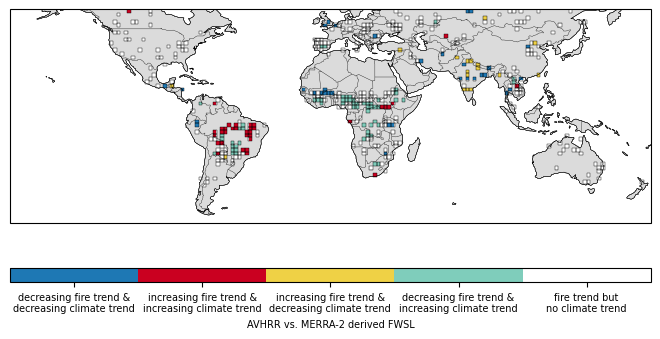

In [29]:
# the array of AVHRR Kendalls tau where p value < 0.1
fires=av_t_masked.copy()  

fwsl_quadrant = np.ones_like(fires) * np.nan
fwsl_quadrant[~np.isnan(fires)] = 5  #this will be the locations where trend in fire but no trend in fw
fwsl_quadrant[(merra_tau_masked<0)&(fires<0)] = 1
fwsl_quadrant[(merra_tau_masked>0)&(fires>0)] = 2
fwsl_quadrant[(merra_tau_masked<0)&(fires>0)] = 3
fwsl_quadrant[(merra_tau_masked>0)&(fires<0)] = 4

# fwsl_quadrant has values 1-4 & nan
nf = 2045 #np.sum(~np.isnan(firescount))
nn = np.sum(~np.isnan(fwsl_quadrant))
n1 = np.sum(fwsl_quadrant==1)
n2 = np.sum(fwsl_quadrant==2)
n3 = np.sum(fwsl_quadrant==3)
n4 = np.sum(fwsl_quadrant==4)
n5 = np.sum(fwsl_quadrant==5)
print('grid cells with frequent fire:', nf)
print('grid cells with a fire trend:', nn)
print('total coincident trends:', n1+n2+n3+n4, (n1+n2+n3+n4)/nn*100)
print('both down:', n1, n1/nn*100)
print('both up:', n2, n2/nn*100)
print('fire up climate down:', n3, n3/nn*100)
print('fire down climate up:', n4, n4/nn*100)
print('fire trend but no climate trend:', n5, n5/nn*100)
print('n agreeing:', n1+n2, (n1+n2)/nn*100)

ticks = [1,2,3,4,5]

tick_labs = [f'decreasing fire trend &\ndecreasing climate trend',
             f'increasing fire trend &\nincreasing climate trend',
             f'increasing fire trend &\ndecreasing climate trend',
             f'decreasing fire trend &\nincreasing climate trend',
             f'fire trend but\nno climate trend']


y = lat2d[np.where((fwsl_quadrant!=0)&(~np.isnan(fwsl_quadrant)))]
x = lon2d[np.where((fwsl_quadrant!=0)&(~np.isnan(fwsl_quadrant)))]


fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d,
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            #arr=firescount,
                            grid_options=False,
                         #mesh_options={'norm': mpl.colors.Normalize(), 
                         #              'cmap': flat_cmap
                         #             },
                            draw_features=['land', 'coast', 'countries']#'lakes'                            
                         )

ax, mesh = utils.geo_plot_ax(fig, ax, 
                             lons=lon2d,
                             lats=lat2d,
                             extent = [-180, 180, -60, 60], 
                             arr=fwsl_quadrant,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(), 
                                     'cmap': discrete_cmap
                                      },
                       grid_options=False
                         )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab="AVHRR vs. MERRA-2 derived FWSL", 
                fontsize=7,
                ticks=ticks, ticklab=tick_labs, 
                cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 45}, 
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

#fig.savefig(os.path.join(dir_out_figures, '02_fwsl_quadrant_map.png'), dpi=1000)
#fig.savefig(os.path.join(dir_out_figures, '02_fwsl_quadrant_map.pdf'))
fig.savefig(os.path.join(dir_out, '03b_fwsl_quadrant_map_MERRA2.png'), dpi=1000)

# Check for existance of gridded change points
* load both the gridded AVHRR data, and the change point data produced in R based on this

In [40]:
dir_cp = os.path.join(dir_base,'change_points')
fp_avhrr = os.path.join(dir_base, "avhrr_gridded_0_1_deg_annual_1986_2016.npy")

some setup for working with the gridded count data

In [41]:
# if coarsen > 1, spatial resolution will be coarsened by aggregating this 
# many input grid cells (if input is 0.1 deg, coarsen == 20 -> 2 degree grid)
coarsen = 20
# list of years to compile
all_years = np.arange(1986,2016+1)
# define input grid parameters
res = 0.1
# matplotlib expects plotting in inches, this conversion factor lets us specify it in mm
mm = 1/25.4

# get evenly spaced lat/lons
lat1d_raw = np.linspace(90. - res / 2., -90. + res / 2., num=int(180 / res))
lon1d_raw = np.linspace(0. + res / 2., 360. - res / 2., num=int(360 / res)) - 180
offset_raw = abs(lon1d_raw[0] - lon1d_raw[1]) / 2
lon2d_raw, lat2d_raw = np.meshgrid(lon1d_raw, lat1d_raw)

# recalc these if inputs should be coarsened
if coarsen != 1:
    lat1d = np.linspace(lat1d_raw[:coarsen].mean(), lat1d_raw[-coarsen:].mean(), int(lat1d_raw.shape[0] / coarsen))
    lon1d = np.linspace(lon1d_raw[:coarsen].mean(), lon1d_raw[-coarsen:].mean(), int(lon1d_raw.shape[0] / coarsen))
else:
    lat1d = lat1d_raw
    lon1d = lon1d_raw

# get corresponding 2D grids of lat/lon
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

#useful for plotting
pixel_spacing = int(lat1d[0] - lat1d[1])
offset = abs(lon1d[0] - lon1d[1]) / 2

now coarsen the avhrr gridded data and make some useful intermediate data for plotting

In [43]:
# load and coarsen the AVHRR data
av = np.load(fp_avhrr)
av = np.roll(av, 1800, axis=2)

# sum fire counts to a coarser grid if required
if coarsen != 1:
    print(f'old dims: {av.shape}')
    av = utils.grid_coarsen(arr=av, c=coarsen)
    print(f'new dims: {av.shape}')

# calculate the mean grid cell fire count for the AVHRR years we use within 1986-2016
av_mean = np.nanmean(av, axis=0)
av_mean[av_mean==0] = np.nan
#mask some inconsequential but distracting small island activity 
av_mean[44:46,43:45] = np.nan
av_mean[51:55,172:179] = np.nan

# binary array of frequent fire locations based on mean fire activity
firescount = np.zeros_like(av_mean) * np.nan
firescount[av_mean>=1] = 1

old dims: (31, 1800, 3600)
new dims: (31, 90, 180)


In [44]:
cp = np.round(np.load(os.path.join(dir_cp, "R_OUTPUT_avhrr_2deg_ChangePoints.npy")),0)
cpupper = np.round(np.load(os.path.join(dir_cp, "R_OUTPUT_avhrr_2deg_ChangePoints_upperCI.npy")),0)
cplower = np.round(np.load(os.path.join(dir_cp, "R_OUTPUT_avhrr_2deg_ChangePoints_lowerCI.npy")),0)
cp_diff = cpupper - cplower
print('cp:', np.nanmin(cp), np.nanmax(cp))
print('cp_lower:', np.nanmin(cplower), np.nanmax(cplower))
print('cp_upper:',np.nanmin(cpupper), np.nanmax(cpupper))
print('cp_diff:', np.nanmin(cp_diff), np.nanmax(cp_diff))

cp: 1989.0 2015.0
cp_lower: 1837.0 2015.0
cp_upper: 1990.0 2155.0
cp_diff: 0.0 318.0


In [45]:
"""
Apply rules to tighten up CPs:
* CP must be > 5 years from start/end (i.e. 1991-2011) OR HAVE AT LEAST 5 YEARS OF DATA (i.e.1997-2011)
* 95%CI must not extend beyond 1986 or 2016
* 95%CI must not be greater than 10 years 
"""
cp_filter = cp.copy()
cp_filter[cp < 1997] = np.nan
cp_filter[cp > 2011] = np.nan
cp_filter[cplower < 1986] = np.nan
cp_filter[cpupper > 2016] = np.nan
cp_filter[cp_diff > 10] = np.nan
print('cp_filter:', np.nanmin(cp_filter), np.nanmax(cp_filter))

cp_filter: 1997.0 2011.0


(array([ 5.,  3.,  2.,  1.,  4.,  2.,  6., 14.,  6., 10.,  9.,  8., 15.,
        37.]),
 array([1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
        2006., 2007., 2008., 2009., 2010., 2011.]),
 <BarContainer object of 14 artists>)

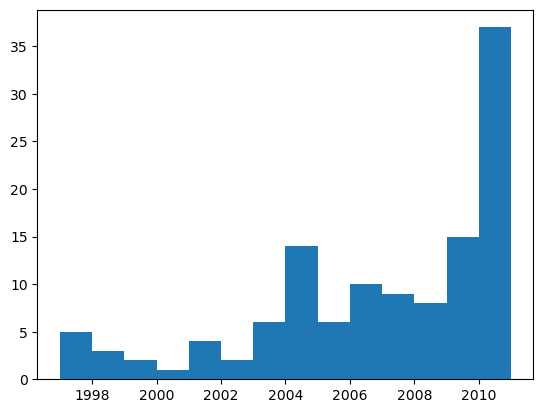

In [47]:
mpl.pyplot.hist(cp_filter[~np.isnan(cp_filter)],bins=14)

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


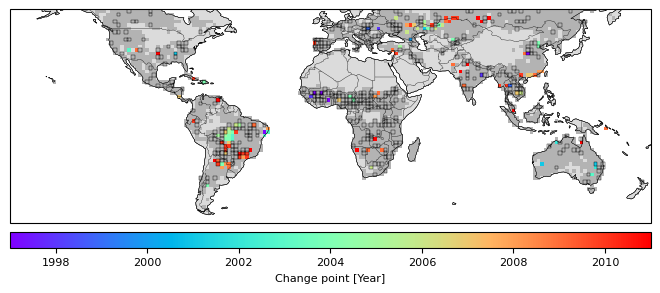

In [48]:
# make a plot with frequent fire grids
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                                lons=lon1d,# - offset, 
                                lats=lat1d, #+ offset, 
                                extent = [-180, 180, -60, 66],
                                arr=firescount,
                                grid_options=None,
                                mesh_options={'norm': mpl.colors.Normalize(), 
                                              'cmap': flat_cmap},
                                draw_features=['land', 'coast', 'countries']
                             )

# now add the grid cells with trends (all significance)
ax, mesh = utils.geo_plot_ax(fig, ax, 
                       lons=lon1d,# - offset,
                       lats=lat1d,# - offset,
                       extent = [-180, 180, -60, 60],
                       arr=cp_filter,
                       grid_options=None,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(vmin=1997, vmax=2011), 
                                     'cmap': 'rainbow'}
                         )

# add square markers where p < 0.1 for the main 30 year trend plot.
# unsurprisingly, many of these do not align well 
# (places with changing trend unlikely to have strong trend over entire timeseries)
y = lat2d[np.where(~np.isnan(av_t_masked))]
x = lon2d[np.where(~np.isnan(av_t_masked))]

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab=r"Change point [Year]",
                cbax_options={'location': 'bottom', 'pad': 0.01, 'shrink': 1, 'aspect': 40}, # 'pad': 0.05 'shrink': 1, 'aspect': 40
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

#fig.savefig(os.path.join(dir_cp, 'avhrr_year_of_change_mapped_2deg.png'), dpi=1000)

array([1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011.,   nan])

In [93]:
### ~100 cells with change points in total
y_ix, x_ix = np.where(~np.isnan(cp_filter))
print(f'number of grid cells with change points: {y_ix.shape}') 

y_ix2, x_ix2 = np.where(~np.isnan(firescount))
print(f'number of grid cells with frequent fire: {y_ix2.shape}') 
print(f'percentage: {y_ix.shape[0] / y_ix2.shape[0] * 100}')

### number of grid cells that both have a monotonic trend and have a change point:
coincident = np.where(
                      (~np.isnan(cp_filter)) 
                      & 
                      (~np.isnan(av_t_masked))
                     )
y_ix3, x_ix3 = np.where(~np.isnan(coincident))
print(f'number of grid cells that both have a monotonic trend and have a change point: {y_ix3.shape}') 

y_ix4, x_ix4 = np.where(~np.isnan(av_t_masked))
print(f'n grid cells with trends: {y_ix4.shape}') 
print(f'percentage: {y_ix3.shape[0] / y_ix4.shape[0] * 100}')

number of grid cells with change points: (122,)
number of grid cells with frequent fire: (2045,)
percentage: 5.965770171149145
number of grid cells that both have a monotonic trend and have a change point: (62,)
n grid cells with trends: (415,)
percentage: 14.93975903614458


lots of interesting change points at grid cell scale. Now calculate the strength, direciton, and significance of trend before and after each change point.

In [57]:
df_cp = pd.DataFrame()

t1 = np.zeros_like(cp_filter) * np.nan
p1 = np.zeros_like(cp_filter) * np.nan
s1 = np.zeros_like(cp_filter) * np.nan
t2 = np.zeros_like(cp_filter) * np.nan
p2 = np.zeros_like(cp_filter) * np.nan
s2 = np.zeros_like(cp_filter) * np.nan

y_ix, x_ix = np.where(~np.isnan(cp_filter))

for i, pair in enumerate(zip(y_ix, x_ix)):
    df_tmp = pd.DataFrame()
    #current cp
    cp_year = cp_filter[pair[0], pair[1]].astype(int)
    
    # subset data
    depth_mask = ~np.isnan(av[:, pair[0], pair[1]])
    fires = av[:, pair[0], pair[1]][depth_mask]
    yrs = np.array(all_years)[depth_mask]  
    # normalise all fire data to 1986
    if fires[0] == 0:
        fires = fires + 1
    else:
        fires = fires / fires[0]
    
    # stats for 1st section =======================
    mask = (yrs <= cp_year)
    
    # fit 1
    tau, p_value = stats.kendalltau(x=yrs[mask], y=fires[mask])
    slope, intercept, _, _ = stats.theilslopes(x=yrs[mask], y=fires[mask])
    #fill the df
    df_tmp = pd.DataFrame()
    df_tmp['y'] = pd.Series(pair[0])
    df_tmp['x'] = pair[1]
    df_tmp['section'] = 1
    df_tmp['cp_year'] = cp_year
    df_tmp['tau'] = tau
    df_tmp['p_value'] = p_value
    df_tmp['slope'] = slope
    df_tmp['intercept'] = intercept
    df_cp = pd.concat([df_cp, df_tmp])
    
    #fill the arrays
    t1[pair[0], pair[1]] = tau
    p1[pair[0], pair[1]] = p_value
    s1[pair[0], pair[1]] = slope    
    
    
    # stats for 2nd section =======================
    mask = (yrs > cp_year)
    
    # fit
    tau, p_value = stats.kendalltau(x=yrs[mask], y=fires[mask])
    slope, intercept, _, _ = stats.theilslopes(x=yrs[mask], y=fires[mask])
    #fill the df
    df_tmp = pd.DataFrame()
    df_tmp['y'] = pd.Series(pair[0])
    df_tmp['x'] = pair[1]
    df_tmp['section'] = 2
    df_tmp['cp_year'] = cp_year
    df_tmp['tau'] = tau
    df_tmp['p_value'] = p_value
    df_tmp['slope'] = slope
    df_tmp['intercept'] = intercept
    df_cp = pd.concat([df_cp, df_tmp])
    
    #fill the arrays
    t2[pair[0], pair[1]] = tau
    p2[pair[0], pair[1]] = p_value
    s2[pair[0], pair[1]] = slope  
print('finished')    

finished


In [58]:
df_cp.head()

,y,x,section,cp_year,tau,p_value,slope,intercept
0,17,108,1,2006,0.418121,0.057780,0.103571,-203.935714
0,17,108,2,2006,-0.690066,0.006606,-0.300000,605.200000
0,17,122,1,2010,0.530547,0.003673,0.431677,-858.217391
0,17,122,2,2010,-0.233550,0.537453,0.000000,1.500000
0,17,124,1,2010,0.372642,0.044006,0.215385,-427.200000


freq fire grid cells: 2045
no of sig trends: 97


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


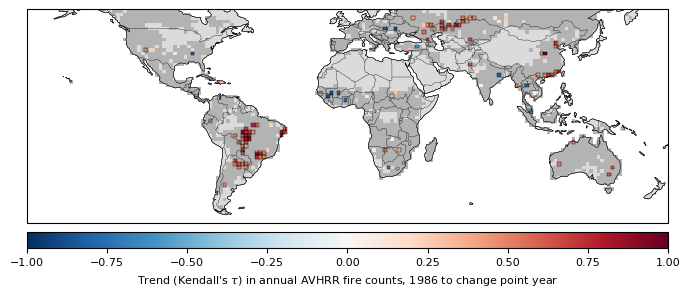

In [59]:
# get locations of significant (p < 0.1) points
pval_mask = (p1 < 0.1)
#y, x = np.where(pval_mask)
y = lat2d[pval_mask]
x = lon2d[pval_mask]

# calc and print some stats for info ====
nf = np.sum(~np.isnan(firescount))
nn = y.shape[0]
print('freq fire grid cells:', nf)
print('no of sig trends:', nn)

# make a plot with frequent fire grids
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                                lons=lon1d,
                                lats=lat1d,
                                extent = [-180, 180, -60, 66],
                                arr=firescount,
                                grid_options=None,
                                mesh_options={'norm': mpl.colors.Normalize(), 
                                              'cmap': flat_cmap},
                                draw_features=['land', 'coast', 'countries']
                             )

# now add the grid cells with trends (all significance)
ax, mesh = utils.geo_plot_ax(fig, ax, 
                       lons=lon1d,# - offset,
                       lats=lat1d,# - offset,
                       extent = [-180, 180, -60, 60],
                       arr=t1,
                       grid_options=None,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(vmin=-1.0, vmax=1.0), 
                                     'cmap': 'RdBu_r'}
                         )

# add square markers where p < 0.1
ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab=r"Trend (Kendall's $\tau$) in annual " 
                "AVHRR fire counts, 1986 to change point year", 
                cbax_options={'location': 'bottom', 'pad': 0.01, 'shrink': 1, 'aspect': 40}, # 'pad': 0.05 'shrink': 1, 'aspect': 40
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

#fig.savefig(os.path.join(dir_cp, 'avhrr_trend_before_change_2deg.png'), dpi=1000)

freq fire grid cells: 2045
no of sig trends: 50


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


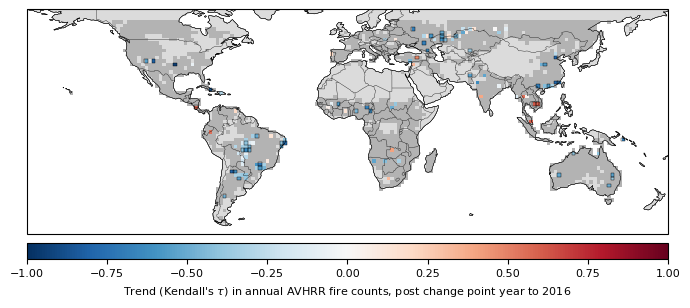

In [64]:
# get locations of significant (p < 0.1) points
pval_mask = (p2 < 0.1)
#y, x = np.where(pval_mask)
y = lat2d[pval_mask]
x = lon2d[pval_mask]

# calc and print some stats for info ====
nf = np.sum(~np.isnan(firescount))
nn = y.shape[0]
print('freq fire grid cells:', nf)
print('no of sig trends:', nn)

# make a plot with frequent fire grids
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                                lons=lon1d,
                                lats=lat1d,
                                extent = [-180, 180, -60, 66],
                                arr=firescount,
                                grid_options=None,
                                mesh_options={'norm': mpl.colors.Normalize(), 
                                              'cmap': flat_cmap},
                                draw_features=['land', 'coast', 'countries']
                             )

# now add the grid cells with trends (all significance)
ax, mesh = utils.geo_plot_ax(fig, ax, 
                       lons=lon1d,# - offset,
                       lats=lat1d,# - offset,
                       extent = [-180, 180, -60, 66],
                       arr=t2,
                       grid_options=None,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(vmin=-1.0, vmax=1.0), 
                                     'cmap': 'RdBu_r'}
                         )

# add square markers where p < 0.1
ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab=r"Trend (Kendall's $\tau$) in annual " 
                "AVHRR fire counts, post change point year to 2016", 
                cbax_options={'location': 'bottom', 'pad': 0.01, 'shrink': 1, 'aspect': 40}, # 'pad': 0.05 'shrink': 1, 'aspect': 40
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

#fig.savefig(os.path.join(dir_cp, 'avhrr_trend_after_change_2deg.png'), dpi=1000)

In [67]:
np.sum(pval_mask)

50